In [100]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from IPython.core.interactiveshell import InteractiveShell
from tqdm.notebook import tqdm
from scipy.stats import shapiro, normaltest, kstest

InteractiveShell.ast_node_interactivity = "all"

In [70]:
stocks = [
    "PGSUS.IS",
    "ISCTR.IS",
    "KCHOL.IS",
    "ASELS.IS",
]

In [71]:
data = yf.download(tickers=stocks, period="max",
                   start="2020-01-03")['Adj Close']

data.clip(lower=0, inplace=True)
data.fillna(0, inplace=True)

[*********************100%***********************]  4 of 4 completed


In [72]:
returns = data.pct_change().dropna()
returns.tail()

,ASELS.IS,ISCTR.IS,KCHOL.IS,PGSUS.IS
Date,,,,
2021-08-31,0.005060,0.019504,-0.023729,-0.000708
2021-09-01,-0.011328,-0.005217,0.007812,0.012748
2021-09-02,0.001273,0.005245,-0.001723,-0.002797
2021-09-03,-0.001907,-0.010435,-0.006040,-0.005610
2021-09-06,-0.000637,0.008787,0.004340,0.005642


In [84]:
# Portfolio with random weights
weights = np.random.random(len(stocks))
weights = weights / np.sum(weights)

# Portfolio PnLs
PnL = (weights * returns).sum(axis=1)

In [110]:
percs = [0.1, 1, 5]
var = np.percentile(PnL, percs, interpolation="lower")
print('%16s %16s' % ('Confidence Level', 'Value-at-Risk'))
print(33 * '-')
for pair in zip(percs, var):
    print('%16.1f %16.5f' % (100 - pair[0], -pair[1]))

Confidence Level    Value-at-Risk
---------------------------------
            99.9          0.10379
            99.0          0.05813
            95.0          0.03256


In [85]:
# Historical VaRs
# https://medium.com/@matt_84072/historical-simulation-value-at-risk-explained-with-python-code-a904d848d146
var_1p = np.percentile(PnL, 1, interpolation="lower")
var_5p = np.percentile(PnL, 5, interpolation="lower")

print(f"Historical 99% VaR: {var_1p}")
print(f"Historical 95% VaR: {var_5p}")

Historical 99% VaR: -0.05813094911174911
Historical 95% VaR: -0.03255777292807174


[Text(0.5, 6.79999999999999, 'PnL'),
 Text(0.42499999999999716, 0.5, 'Probability')]

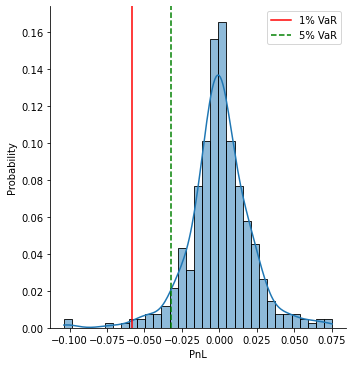

In [111]:
fig = sns.displot(PnL, kde=True, stat="probability").axes.flatten()
fig[0].axvline(var_1p, c="r", linestyle="-", label="1% VaR")
fig[0].axvline(var_5p, c="g", linestyle="--", label="5% VaR")
fig[0].legend()
fig[0].set(xlabel='PnL', ylabel='Probability')

In [80]:
# Bootstrap VaR
def VaR1(data):
    return np.percentile(data, 1, interpolation="lower")


def VaR5(data):
    return np.percentile(data, 5, interpolation="lower")


def bootstrap(data, func):
    sample = np.random.choice(data, len(data))
    return func(sample)


def draw_bs_reps(data, func, size):
    bs_reps = np.empty(size)
    for i in tqdm(range(size)):
        bs_reps[i] = bootstrap(data, func)
    return bs_reps


bs_var_1 = draw_bs_reps(PnL, VaR1, 5000)
bs_var_5 = draw_bs_reps(PnL, VaR5, 5000)

print(f"Bootstrap 99% VaR: {np.mean(bs_var_1)}")
print(f"Confidence intervals: {np.percentile(bs_var_1, [2.5, 97.5])}")

print(f"Bootstrap 95% VaR: {np.mean(bs_var_5)}")
print(f"Confidence intervals: {np.percentile(bs_var_5, [2.5, 97.5])}")

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Bootstrap 99% VaR: -0.06626183287860131
Confidence intervals: [-0.09966348 -0.05024794]
Bootstrap 95% VaR: -0.035440180885582526
Confidence intervals: [-0.0478463  -0.02684057]


In [116]:
# Conditional VaR - Expected tail loss - Expected shortfall
exp_sf_1p = PnL[PnL < var_1p].mean()
exp_sf_5p = PnL[PnL < var_5p].mean()

exp_sf_1p
exp_sf_5p

-0.08570424750973445

-0.0522112397056073